In [8]:
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras import Model
from tensorflow.keras.losses import Loss
from tensorflow.keras.layers import Layer, Conv2D, Input
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, UpSampling2D, Input

class Encoder(Model):
    def __init__(self, input_dim):
        super(Encoder, self).__init__()
        # Assuming the input_dim is 28x28x1 for the MNIST dataset
        self.conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')
        self.max_pool = MaxPooling2D(pool_size=(2, 2))  # This will reduce 28x28 to 14x14

    def call(self, x):
        x = self.conv1(x)
        x = self.max_pool(x)
        return x


class Decoder(Model):
    def __init__(self):
        super(Decoder, self).__init__()
        self.up_sample = UpSampling2D((2, 2))  # This will increase 14x14 to 28x28
        self.conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')
        self.conv2 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')

    def call(self, x):
        x = self.up_sample(x)
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class Autoencoder(Model):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_dim)
        self.decoder = Decoder()

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


def reconstruction_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Load MNIST dataset as done in the original code
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train.astype('float32') / 255., -1)
x_test = np.expand_dims(x_test.astype('float32') / 255., -1)


input_dim = (28,28,1)
latent_dim = 2
model = Autoencoder(input_dim)
optimizer = tf.optimizers.Adam()
loss=reconstruction_loss
model.compile(loss=loss, optimizer=optimizer)

# Commented out IPython magic to ensure Python compatibility.
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((x_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)


epochs = 1
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train) in enumerate(train_dataset):
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:
            prediction = model(x_batch_train, training=True)  # Logits for this minibatch
#             print('L2M_encoder_1',L2M_encoder_1.shape)
#             print('L2M_decoder_1',L2M_decoder_1.shape)
            # Compute the loss value for this minibatch.
            loss_value = loss(x_batch_train, prediction)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Log every 200 batches.
        if step % 200 == 0:
          print("Training loss (for one batch) at step %d: %.4f" % (step, float(loss_value)))
          print("Seen so far: %s samples" % ((step + 1) * batch_size))



Start of epoch 0
Training loss (for one batch) at step 0: 0.2352
Seen so far: 32 samples
Training loss (for one batch) at step 200: 0.0031
Seen so far: 6432 samples
Training loss (for one batch) at step 400: 0.0025
Seen so far: 12832 samples
Training loss (for one batch) at step 600: 0.0022
Seen so far: 19232 samples
Training loss (for one batch) at step 800: 0.0017
Seen so far: 25632 samples
Training loss (for one batch) at step 1000: 0.0017
Seen so far: 32032 samples
Training loss (for one batch) at step 1200: 0.0016
Seen so far: 38432 samples
Training loss (for one batch) at step 1400: 0.0015
Seen so far: 44832 samples
Training loss (for one batch) at step 1600: 0.0013
Seen so far: 51232 samples
Training loss (for one batch) at step 1800: 0.0012
Seen so far: 57632 samples


1/1 [==============================] - 0s 52ms/step


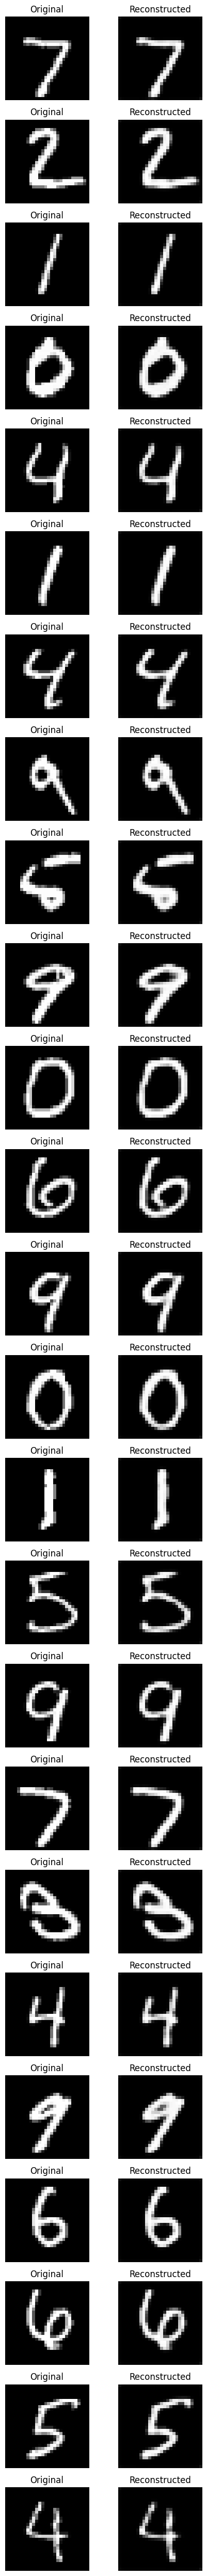

In [10]:
x_recon = model.predict(x_test[:25])
num_images = x_recon.shape[0]

# Set up the matplotlib figure and axes based on the number of images
fig, axes = plt.subplots(nrows=num_images, ncols=2, figsize=(5, 2*num_images))

for i in range(num_images):
    # Display original images
    axes[i, 0].imshow(x_test[i].squeeze(), cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Original')

    # Display reconstructed images
    axes[i, 1].imshow(x_recon[i].squeeze(), cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Reconstructed')

plt.tight_layout()
plt.savefig('separate_reconstructions.png')
plt.show()
